# Import Package

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
import random
import pathlib

In [3]:
from IPython.display import Image

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { width: 44em; }</style>"))

C:\Users\KJH\AppData\Local\Temp\ipykernel_21948\1266392888.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Load Dataset

## Problem 1
- Image Path(train) : /dataset/train
- Image Path(test) : /dataset/test
- Image Path(valid) : /dataset/valid
- Image Size : Height X Width = 180 X 180
- Batch Size : 32
- percent of data as validation set : 20%

In [5]:
data_dir = ?
batch_size = ?
img_height = ?
img_width = ?
train_ds = tf.keras.preprocessing.image_dataset_from_directory(?)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(?)

## Problem 1 Solution

In [ ]:
data_dir = pathlib.Path('./dataset/train')
batch_size = 32
img_height = 180
img_width = 180
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

# Visualize our data

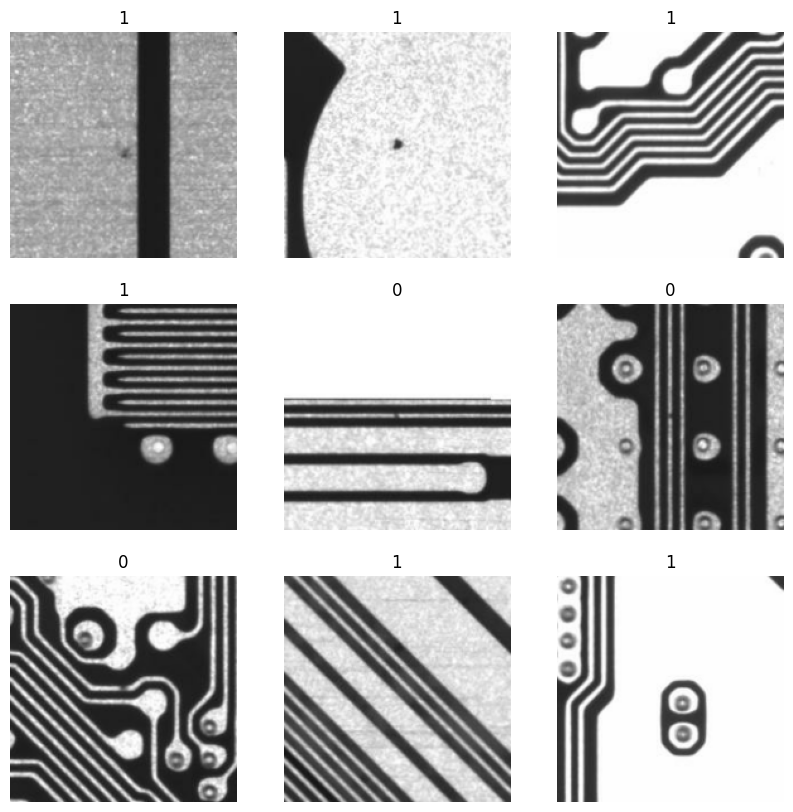

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

`image_batch` 및 `labels_batch` 텐서에서 `.numpy()`를 호출하여 이를 `numpy.ndarray`로 변환할 수 있습니다.


In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Normalization 

In [14]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.14249568 1.0


# CNN Archetecture
![nn](asset/simpleCNN_tensorflow.JPG)

# Build CNN

## Problem 2
- Class = 2
- Image Height : 180 , Image Width : 180 , channel : 3
- padding='same'
- activation='relu'

In [ ]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(?, input_shape=(?, ?, ?)),
  layers.Conv2D(?, ?, ?, ?),
  layers.MaxPooling2D(),
  layers.Conv2D(?, ?,  ?, ?),
  layers.MaxPooling2D(),
  layers.Conv2D(?, ?,  ?, ?),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(?, ?),  
  layers.Dense(?)
])

## Problem 2 Solution

In [26]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)),
  layers.Conv2D(32, 2, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),  
  layers.Dense(2)
])

## Compile Model

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      416       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

## Train Model

In [29]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
5/5 [==============================] - 3s 469ms/step - loss: 0.8230 - accuracy: 0.5875 - val_loss: 0.7098 - val_accuracy: 0.5000
Epoch 2/5
5/5 [==============================] - 2s 447ms/step - loss: 0.6842 - accuracy: 0.5688 - val_loss: 0.7069 - val_accuracy: 0.5000
Epoch 3/5
5/5 [==============================] - 2s 453ms/step - loss: 0.6646 - accuracy: 0.6062 - val_loss: 0.6338 - val_accuracy: 0.6750
Epoch 4/5
5/5 [==============================] - 2s 440ms/step - loss: 0.5745 - accuracy: 0.7125 - val_loss: 0.6809 - val_accuracy: 0.5000
Epoch 5/5
5/5 [==============================] - 2s 450ms/step - loss: 0.5042 - accuracy: 0.7563 - val_loss: 0.5711 - val_accuracy: 0.6750


## Result

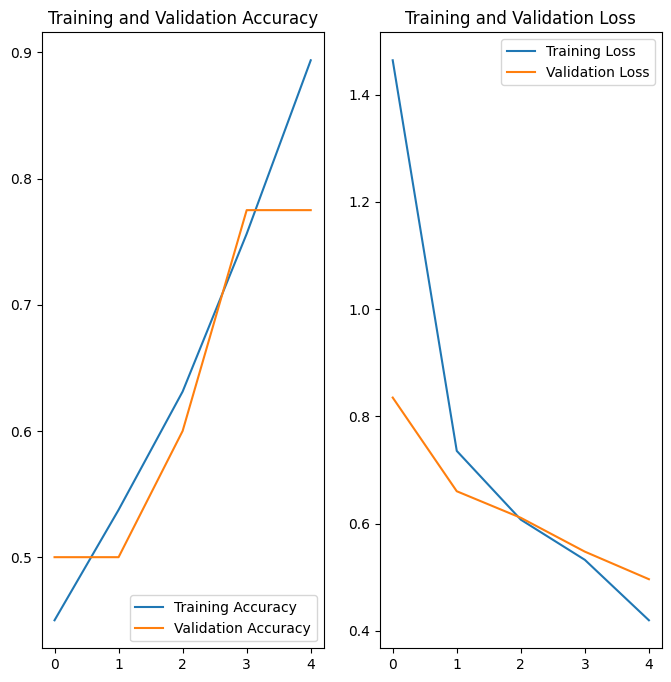

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict

1/1 [==============================] - 0s 16ms/step


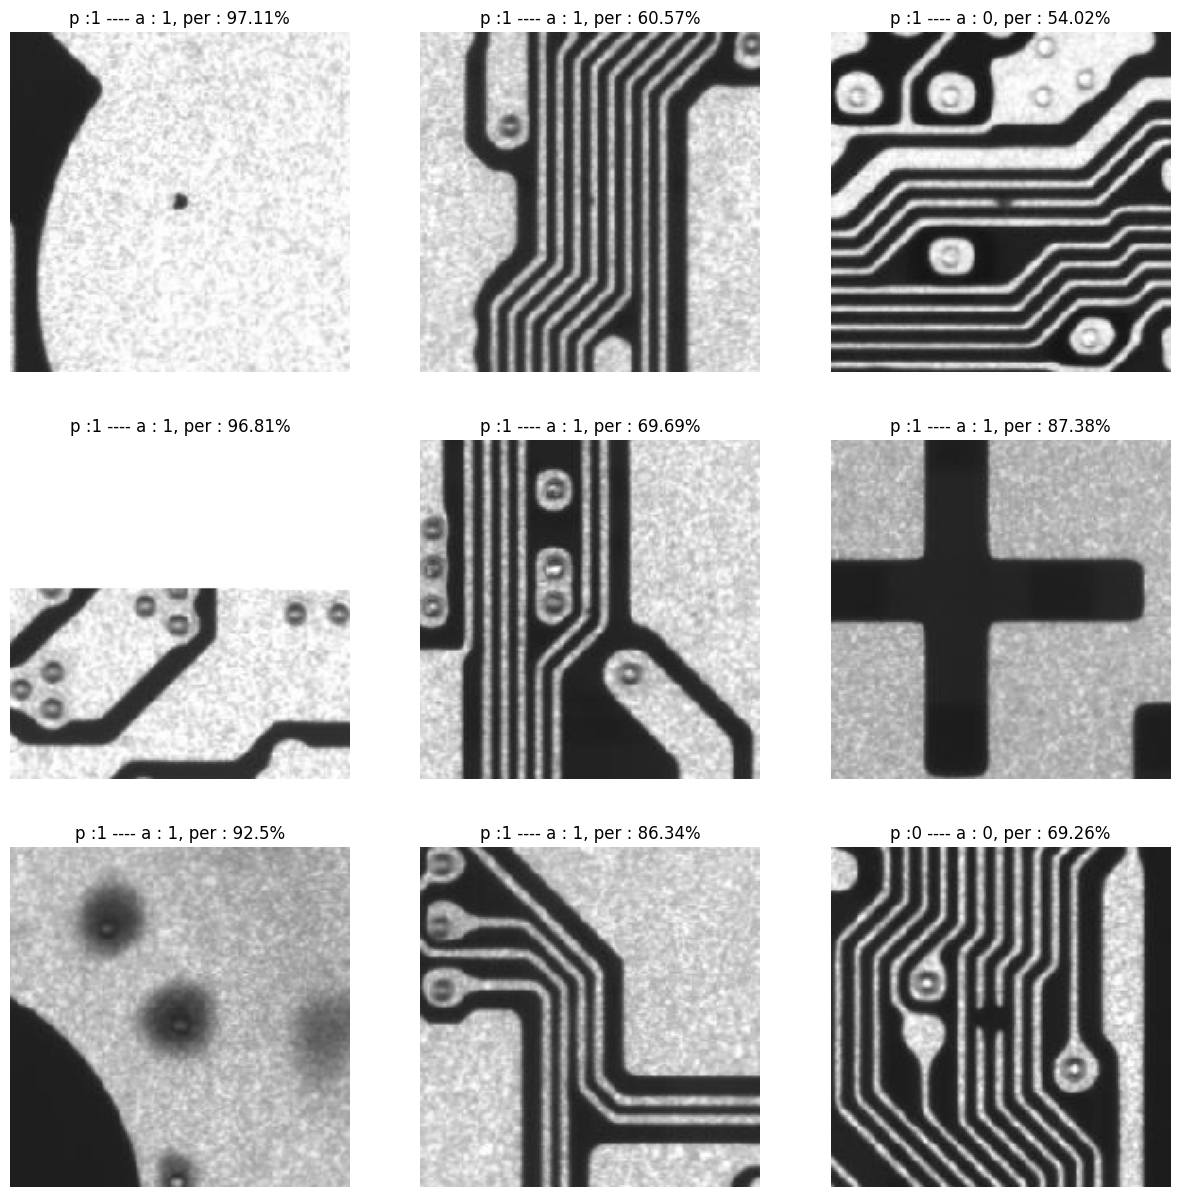

In [31]:
valid_path = glob("./dataset/valid/*/*")
random.shuffle(valid_path)
plt.figure(figsize=(15, 15))
for i, iPath in enumerate(valid_path[0:9]):
    img = keras.preprocessing.image.load_img(
        iPath, target_size=(img_height, img_width)
    )
    
    if "ng" in iPath:
        labels = 0        
    else:
        labels = 1        
    
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    perc = np.round(100 * np.max(score), 2)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f'p :{class_names[np.argmax(score)]} ---- a : {labels}, per : {perc}%')   
    plt.axis("off")